Load in some libraries. 

In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Begin by defining a function to convert the reliability of a measure into the standard deviation of the measurement error. We do this by assuming that the population standard deviation of the measure is 15, like in the standard scales of the WJ-BRS and TOWRE.

In [2]:
get_meas_err <- function(reliability){
  sigma_obs = 15
  sigma_error = sqrt(-sigma_obs^2 * (reliability - 1))
  
}

Define a vector of reliability values that we'll be investigating.


In [3]:
reliability_vector <- c(0.82, 0.90, 0.98)
# Using our function above, convert reliability array to an array of measurement error standard deviations
noise_vec <- sapply(reliability_vector, get_meas_err)

Now let's list a few parameters for our simulation.

In [4]:
# How many simulations per "experiment"?
nsim = 1000
# What is the true population mean and SD for our reading skill measure?
pop_mu = 100 # As in WJ-BRS/TOWRE
pop_sd = 15 # As in WJ-BRS/TOWRE

# Where is our cutoff for defining "disabled" readers? From 0-1, a fraction. 
cutoff_prop = 0.3 # Lowest thirtieth percentile
cutoff_z = qnorm(cutoff_prop)
cutoff_score = round(pop_mu + cutoff_z * pop_sd) # Round to integer for comparison with standard testing scores
print(paste0("Individuals who score below ", cutoff_score, " are eligible for the intervention."))

[1] "Individuals who score below 92 are eligible for the intervention."


In [5]:
# What population sizes do we want to test?
pop_seq = c(20, 50, 100)
# What is the effect size (cohens-d) measure of the improvement a participant gets from the intervention?
# Remember, we are assuming that effect size is the benefit every individual receives from the intervention.
d_seq <- c(0.4, 0.6, 0.8, 1.0) # d = 1 means every individual improves by 15 points, 1*pop_sd. 
                               # d = 0.4 means every individual improves by 6, 0.4*pop_sd.

Now we write a function that simulates an experiment according to the parameters we've just specified. In this function, we'll:

1. Simulate a normal distribution of readers' "true" reading scores.
2. Add an appropriate amount of measurement noise to the "true" reading scores.
3. Determine which participants are eligible for the intervention on the basis of their measured reading scores.
4. Select participants for the intervention, and update their "true" reading score commensurate to the effect size of the intervention.
5. Simulate the effects of measurement error on the after- intervention reading score assessments
6. Determine which subjects would be considered a non-responder on the basis of not showing detectable improvement in their measured pre- and post- scores. In other words, the difference in scores falls within the 95% confidence interval of the expected measurement error if no change had occurred.



In [6]:
estimate_nr <- function(n,sigma_noise, d, nsim, pop_mu, pop_sd, cutoff){
  
  # Initialize empty vector for keeping track of how many non-responders are present in each simulated experiment. 
  non_responders_proportion <- vector(length = nsim)

  # Based on measurement noise, how big a change would be considered reliably greater than zero?
  diff_sd <- sqrt(2 * sigma_noise^2)
  diff_cutoff <- 1.96 * diff_sd # Say we are following an alpha = 0.05 cutoff to determine slope > 0
  
  for (i in 1:nsim){
    
    # Generate the true scores in a really really big sample
    # Note that n*50 is a good guideline that ensures enough candidates are generated; 
    # if you drastically change the cutoff for inclusion you may need to use a bigger multiplier. Haven't tested.
    true_scores = rnorm(n*50, mean = pop_mu, sd = pop_sd)
    # Account for measurement error in the pre-intervention measures
    score_ests = true_scores + rnorm(n*50, mean = 0, sd = sigma_noise)
    # Get a subset from the sample whose measured scores are in the tail end of the distribution
    candidates_idx = which(score_ests < cutoff)
    samp_measure_t1 <- score_ests[candidates_idx[1:n]] # Take the first n candidates who meet criteria
    samp_true_t1 <- true_scores[candidates_idx[1:n]] # Store their true reading scores
    
    # Now say everyone benefits according to the true effect size 
    samp_true_t2 <- samp_true_t1 + (pop_sd * d) # Update their true reading score
    # Add measurement error to the post-intervention measure
    samp_measure_t2 <- samp_true_t2 + rnorm(length(samp_true_t2), mean = 0, sd = sigma_noise)
    # Put all the subjects' measured scores in a dataframe
    df <- data.frame(t1 = samp_measure_t1,
                     t2 = samp_measure_t2,
                     subj = seq(1,n))
    
    # How many subjects did NOT get reliably better?
    df$delta <- df$t2 - df$t1 # The difference between pre- and post- intervention measurements
    # In how what proportion of participants is the difference not significantly greater than zero?
    non_responders_proportion[i] = (sum(df$delta <= diff_cutoff)/n) 
    
  }
  
  # Now report some summary statistics from our nsim simulations
  mu_pr = mean(non_responders_proportion) # What's the mean proportion of nonresponders?
  sd_pr = sd(non_responders_proportion) # What's the standard deviation of the distribution of proportions?
  # Put it all in a dataframe with some identifying information
  ans_df <- data.frame(mu = mu_pr, 
                       sd = sd_pr,
                       d = d,
                       noise = sigma_noise, 
                       n = n)
  return(ans_df)
}

Let's take it for a spin and see what happens! Note that this can take ~30 seconds depending on how many different experiments you're interested in simulating. 

In [ ]:
out <- data.frame()

for (p in pop_seq){ # for several sample sizes...
 for (d in d_seq){ # for several effect sizes...
   for (v in noise_vec){ # for several measurement reliabilites...
  
    nr_df_tmp <- estimate_nr(p,v,d,nsim, pop_mu,pop_sd,cutoff_score)
    out <- rbind(out, nr_df_tmp)   
   }
 }
}
print("Done! Simulations are complete.")

Time to plot our results (makes Figure 1).

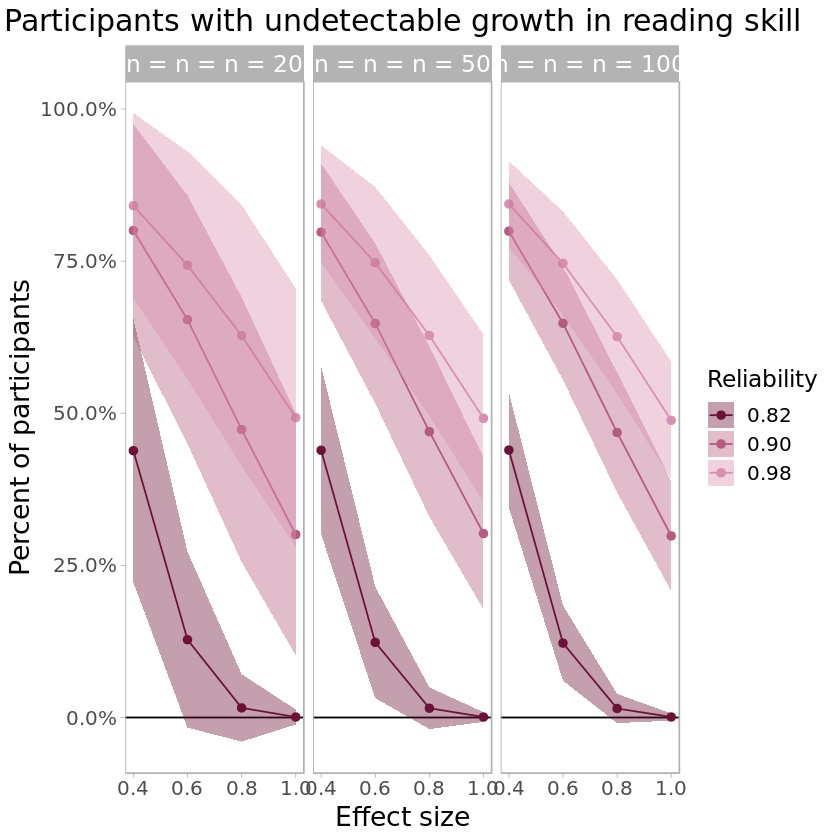

In [10]:
# Change some things to factors for plotting
out$noise <- as.factor(out$noise)
levels(out$noise) <-  sprintf("%.2f", reliability_vector)
out$n <- as.factor(out$n)
levels(out$n) <- paste0("n = ", levels(out$n))

# Set colors- note that if you use more than 3 reliability values, 
# you'll need to add more colors!
palette <- c("#6D1238","#B55B81","#D990AF")

px <- ggplot(out, aes(d, mu))+
  geom_hline(yintercept =  0)+
  geom_point(aes(colour = noise), size = 2)+
  geom_line(aes(colour = noise, group = noise))+
  geom_ribbon(aes(ymin = mu - 1.96*sd, ymax = mu + 1.96*sd,
                group = noise, fill = noise),
                alpha = 0.4)+
  xlab("Effect size")+
  ylab("Percent of participants")+
  scale_y_continuous(labels = scales::percent_format(accuracy = 0.5))+
  scale_x_continuous(breaks = c(0.4,0.6,0.8,1.0))+
  theme_light()+
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 16),
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        plot.title = element_text(size = 18, hjust = 0.5),
        strip.text = element_text(size = 14))+
  scale_color_manual(values = palette, name = "Reliability")+
  scale_fill_manual(values = palette, name = "Reliability")+
  ggtitle("Participants with undetectable growth in reading skill")+
  facet_wrap(~n)

print(px)